# Packages

In [1]:
import numpy as np
import pandas as pd #for loading csv Excel files
import itertools #to merge lists
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl #for plots
from matplotlib import rc, rcParams
import time
from scipy.optimize import curve_fit

# Options for plotting

In [2]:
fontsize=26
legendfontsize=12
font = {'size' : fontsize}
rc('font',**font)
rc('text', usetex=True)
#rc('font', family='serif', serif='Computer Modern Roman')

In [3]:
#Color palette accessible to colorblind people (see https://davidmathlogic.com/colorblind/)
lightblue='#1A85FF'
blue='#005AB5'
darkblue='#222255'
purple='#5D3A9B'
magenta='#AA4499'
red='#DC3220'
orange='#E66100'
yellow='#FFC20A'
green='#40B0A6'

colors=[lightblue,blue,darkblue,purple,magenta,red,orange,yellow,green]

# Constants

In [4]:
c=2.99792458*10.**8.*10.**(-3.) #km/s (not m/s)
GeV_to_cmminus1=5.06*10.**13.
GeV_to_g=1.78*10.**(-24.)

# Data dark photon model

### Classical and Born Approximations on the Transfer Cross-Section
Classical valid when $\frac{m_\chi v}{m_\phi} \equiv 2ab \gg 1$.
Born valid when $\frac{\alpha m_\chi}{m_\phi} \equiv b \ll 1$. 
The approximations are taken from the Appendix of 1302.3898

In [5]:
def sigmaT_Born(a, b, mX, v): #output in GeV^(-2) a, b dimensionless.
    prefactor = 2*np.pi/(a**2*mX**2)
    term1 = np.log(1+ 4*a**2*b**2)
    term2 = -4*a**2*b**2/(1+4*a**2*b**2)
    return prefactor*(term1 + term2)

#classical approximation different from that given in SIDM.nb for large beta
def sigmaT_Classical_Attractive(a, b, mX, v): #output in GeV(-2)
    beta = 1/(2*a**2*b)
    mPhi = (v/c)*1/(2*a)*mX/b
    #print(beta)
    if beta <= 0.1:
        return 4*np.pi*beta**2/(mPhi**2)*np.log(1 + beta**(-1))
    elif 0.1 < beta <= 10**3:
        return 8*np.pi*beta**2/(mPhi**2*(1 + 1.5*beta**(1.65)))
    elif beta > 10**3:
        return np.pi/mPhi**2*(np.log(beta) + 1 - np.log(beta)**(-1)/2)**2


def sigmaT_Classical_Repulsive(a,b,mX,v):
    beta = 1/(2*a**2*b)
    mPhi = (v/c)/(2*a)*mX/b
    if beta<=1:
        return np.pi*2*beta**2/mPhi**2*(1+log(beta)**(-2))
    if beta >1:
        return np.pi/mPhi**2*(log(2*beta)-log(log(2*beta)))**2


In [6]:
potentials=['attractive','repulsive'] 
datadarkphotonmodel=np.array([pd.read_csv('DataDarkPhotonModel/crosssec_'+str(potential)+'.csv',header=None).values for potential in potentials]) #header=-1 needed to load da a from first line.
avals=np.array(datadarkphotonmodel[0][:,0]) #Same avals for both potentials.
#print(avals) 
uniqueavals=np.unique(avals)
#print(uniqueavals)
bvals=np.array(datadarkphotonmodel[0][:,1]) #Same bvals for both potentials.
#print(bvals) 
uniquebvals=np.unique(bvals)
#print(uniquebvals)
print(len(uniquebvals))
cvals=[datadarkphotonmodel[i][:,2] for i in range(0,len(datadarkphotonmodel))]
#print(cvals) 

1001


# Generate 2D interpolation function c(a,b)

In [7]:
#_____Extract lines in data dark photon model with same bvals (repeat each other)_____
ibvals=np.array([list(itertools.chain.from_iterable(np.argwhere(bvals==uniquebvals[i]))) for i in range(0,len(uniquebvals))])
#print(ibvals[0])
#_____For fixed b interpolate in terms of a: c(a)_____
###Note: Small, negligible differences between linear and cubic interpolation function. Interpolation function might break down when extrapolating to values far outside the range of [a,b]. 
#caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='linear') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
caint=np.array([[interp1d([avals[k] for k in ibvals[j]],[cvals[i][k] for k in ibvals[j]],kind='cubic',fill_value='extrapolate') for j in range(0,len(ibvals))] for i in range(0,len(potentials))])
#print(caint)

In [8]:
#_____2D interpolation function c(a,b)_____
def cab_old(potential,a,b):
    if potential=='attractive':
        caInt=caint[0]
    elif potential=='repulsive':
        caInt=caint[1]
    #_____Evaluate all interpolation functions c(b) at b and interpolate in terms of a: c(a,b)_____
    cavals=[caInt[i](a) for i in range(0,len(caInt))]
    cab=interp1d(uniquebvals,cavals,kind='cubic',fill_value='extrapolate')(b) #,kind='cubic',fill_value='extrapolate'
    return cab
    
for potential in ['attractive']: #['attractive','repulsive']:
    for b in [0.1]: #[0.1,10.,100.,1000.,10000.]
        for a in [avals[0],avals[1],10**(-10.)]:
            print([a,b,cab_old(potential,a,b)])

[1e-05, 0.1, array(1.10814e-14)]
[1.05925e-05, 0.1, array(1.24335e-14)]
[1e-10, 0.1, array(-5.79385703e-16)]


Define a function which interpolates if the data points are known. Otherwise, in the Born and Classical regime, it approximates the cross-section using the formulas provided above.

In [20]:
@np.vectorize
def cab(potential, a,b, mX, v):
    if potential == 'attractive':
        caInt = caint[0]
        cavals=[caInt[i](a) for i in range(0,len(caInt))]
        cab=interp1d(uniquebvals,cavals,kind='cubic', fill_value = '1e100', bounds_error = False)(b)
        if cab == 1e100 and b < 1 and 2*a*b < 1:
            #print('Born Limit')
            return sigmaT_Born(a, b, mX, v)* mX**2*(v/c)**2/(16*np.pi)
        elif cab == 1e100 and 2*a*b > 1:
            #print('Classical Limit')
            return sigmaT_Classical_Attractive(a,b,mX, v)* mX**2 * (v/c)**2/(16*np.pi)
        return cab
    elif potential == 'repulsive':
        return print('Error: Repulsive potential not implemented yet.')

In [10]:
print(cab('attractive', 0.0016678204759907602, 2000.0,1000,100))
print(cab_old('attractive',0.0016678204759907602, 2000.0))

68.83345143839658
68.83345143839658


# sigmaT(v)

In [11]:
@np.vectorize
def sigmaT(potential,a,b, mX,v):
    sigmaT=(16.*np.pi*cab(potential,a,b,mX,v))/((mX*GeV_to_cmminus1)**2.*(v**2/c**2.)) #cm**2
    return sigmaT

def sigmaT_over_m(potential,a,b,mX,v):
    sigmaT_over_m=sigmaT(potential,a,b,mX,v)/(mX*GeV_to_g) #cm**2/g
    return sigmaT_over_m

def sigmaT_times_m2(potential,a,b,mX,v):
    sigmaT_times_m2=sigmaT_over_m(potential,a,b,mX,v)*mX**3. #cm**2/g*GeV**3.
    return sigmaT_times_m2

for potential in ['attractive']: #['attractive','repulsive']:
    for a in [0.1]:
        for mX in [200]: #GeV
            for b in [10**3]: #GeV.
                for v in [1000]: #km/s
                    print('sigmaT [cm^2]='+str(sigmaT(potential,a,b,mX,v)))
                    print('sigmaT/m [cm^2/g]='+str(sigmaT_over_m(potential,a,b,mX,v)))
                    print('sigmaT*m [(cm^2/g) GeV^3]='+str(sigmaT_times_m2(potential,a,b,mX,v)))

sigmaT [cm^2]=8.404075654376191e-21
sigmaT/m [cm^2/g]=23.606954085326382
sigmaT*m [(cm^2/g) GeV^3]=188855632.68261105


Plotting $\sigma/m$ as a function of $v$:

In [12]:
vvals= np.logspace(0,4,100);
arange = np.logspace(-5,1,50);
brange = np.logspace(-1,4,50);
bvals,avals = np.meshgrid(brange,arange)

In [148]:
#sigma_vals_dwarves = sigmaT_over_m('attractive',avals,bvals,100,10)

In [149]:
#v_cluster = 1000
#sig_vals_cluster = sigmaT_over_m('attractive',avals,bvals,100,2000)

In [223]:
#start = time.time()
#sigma_vals_dwarves_1000 = sigmaT_over_m('attractive',avals,bvals,1000,10)
#sig_vals_cluster_1000 = sigmaT_over_m('attractive',avals,bvals,1000,2000)
#sigma_vals_dwarves_10 = sigmaT_over_m('attractive',avals,bvals,10,10)
#sig_vals_cluster_10 = sigmaT_over_m('attractive',avals,bvals,10,2000)
#end = time.time()
#print(end-start)

1018.2241542339325


In [266]:
#np.save('sig_dwarves_100GeV.npy',sigma_vals_dwarves)
#np.save('sig_dwarves_10GeV.npy',sigma_vals_dwarves_10)
#np.save('sig_dwarves_1000GeV.npy',sigma_vals_dwarves_1000)
#np.save('sig_clusters_100GeV.npy',sig_vals_cluster)
#np.save('sig_clusters_10GeV.npy',sig_vals_cluster_10)
#np.save('sig_clusters_1000GeV.npy',sig_vals_cluster_1000)

In [13]:
sigma_vals_dwarves= np.load('sig_dwarves_100GeV.npy')
sigma_vals_dwarves_10 = np.load('sig_dwarves_10GeV.npy')
sig_vals_cluster = np.load('sig_clusters_100GeV.npy')
sig_vals_cluster_10 = np.load('sig_clusters_10GeV.npy')

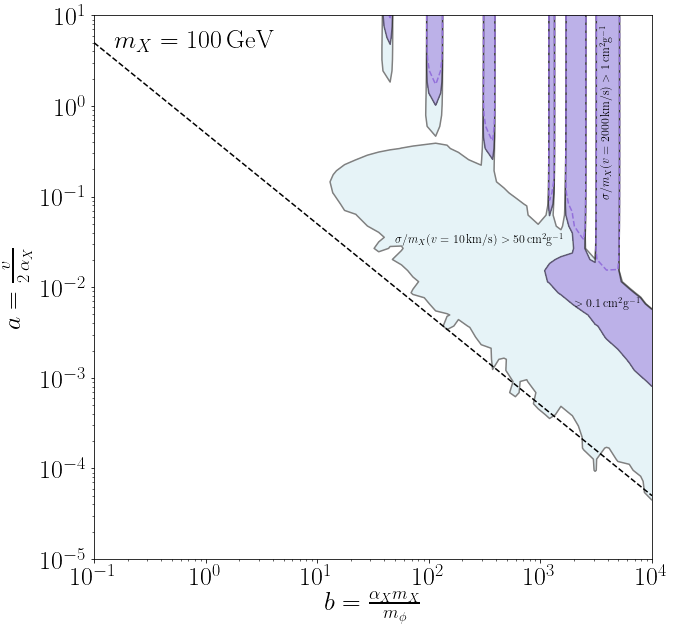

In [14]:
Classical_regime = 2*avals*bvals

fig,ax = pl.subplots(figsize=(10,10))
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$b = \frac{\alpha_X m_X}{m_\phi}$')
pl.ylabel(r'$a = \frac{v}{2\,\alpha_X}$')
CS1=pl.contour(bvals,avals,sigma_vals_dwarves,[50,1e20], colors = ('grey', 'grey'))
CS01 = pl.contourf(bvals,avals,sigma_vals_dwarves,[50,1e20], colors = ('lightblue'), alpha = 0.3)
CS2=pl.contour(bvals,avals, sig_vals_cluster,[0.1,1e20], colors = ('black','black'), alpha = 0.5)
CS02 =pl.contourf(bvals,avals, sig_vals_cluster, [0.1,1e20],colors = ('mediumpurple'), alpha =0.5)
CS02a = pl.contour(bvals,avals,sig_vals_cluster,[1], colors = ('mediumpurple'), linestyles = ('dashed'))
CS_Classical = pl.contour(bvals,avals,Classical_regime,[1], colors = ('black'), linestyles = ('dashed'))
pl.text(50,0.03,r'$\sigma/m_X (v = 10\,\mathrm{km/s}) > 50\,\mathrm{cm}^{2}\mathrm{g}^{-1}$', fontsize = 12);
pl.text(3500,0.1,r'$\sigma/m_X (v = 2000\,\mathrm{km/s}) > 1\,\mathrm{cm}^{2}\mathrm{g}^{-1}$',fontsize=12, rotation=90);
pl.text(2000,0.006,r'$> 0.1\,\mathrm{cm}^{2}\mathrm{g}^{-1}$',fontsize=12);
pl.text(0.15,4,r'$m_X = 100 \,\mathrm{GeV}$');

The dotted line delienates the classical regime or $2 a b = 1$. 

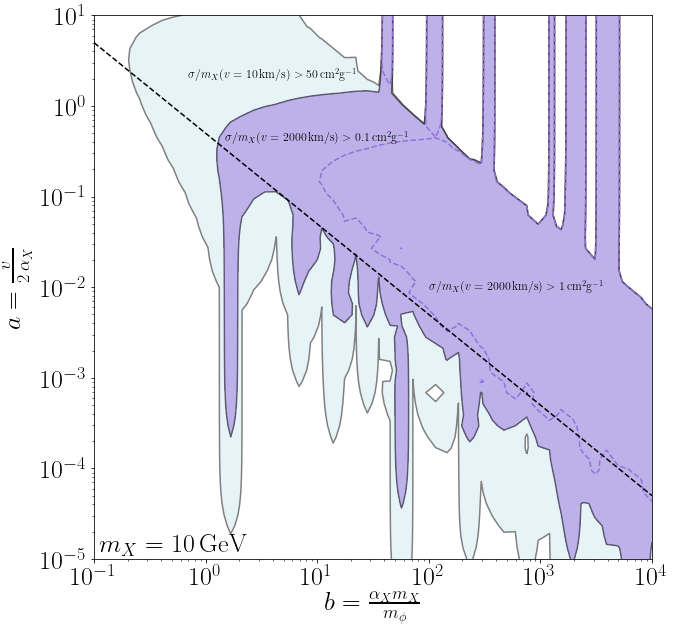

In [15]:
fig,ax = pl.subplots(figsize=(10,10))
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$b = \frac{\alpha_X m_X}{m_\phi}$')
pl.ylabel(r'$a = \frac{v}{2\,\alpha_X}$')
CS1=pl.contour(bvals,avals,sigma_vals_dwarves_10,[50,1e20], colors = ('grey', 'grey'))
CS01 = pl.contourf(bvals,avals,sigma_vals_dwarves_10,[50,1e20], colors = ('lightblue'), alpha = 0.3)
CS2=pl.contour(bvals,avals, sig_vals_cluster_10,[0.1,1e20], colors = ('black','black'), alpha = 0.5)
CS02 =pl.contourf(bvals,avals, sig_vals_cluster_10, [0.1,1e20],colors = ('mediumpurple'), alpha =0.5)
CS02a = pl.contour(bvals,avals,sig_vals_cluster_10,[1],colors = ('mediumpurple'), linestyles = ('dashed'))
CS_Classical = pl.contour(bvals,avals,Classical_regime,[1], colors = ('black'), linestyles = ('dashed'))
pl.text(0.7,2,r'$\sigma/m_X (v = 10\,\mathrm{km/s}) > 50\,\mathrm{cm}^{2}\mathrm{g}^{-1}$', fontsize = 12);
pl.text(100,0.009,r'$\sigma/m_X (v = 2000\,\mathrm{km/s}) > 1\,\mathrm{cm}^{2}\mathrm{g}^{-1}$',fontsize=12);
pl.text(1.5,0.4,r'$\sigma/m_X (v = 2000\,\mathrm{km/s}) > 0.1\,\mathrm{cm}^{2}\mathrm{g}^{-1}$',fontsize=12);
pl.text(0.11,1.1e-5,r'$m_X = 10 \,\mathrm{GeV}$');


# Self-Interactions in terms of $m_X$ and $m_\phi$

In [21]:
@np.vectorize
def sigmaT_gen(potential, alphaX, mX,mPhi,v):
    a = v/(2*alphaX)
    b = alphaX*mX/mPhi
    sigmaT=(16.*np.pi*cab(potential,a,b,mX,v))/((mX*GeV_to_cmminus1)**2.*(v**2/c**2.)) #cm**2
    return sigmaT

def sigmaT_over_m_gen(potential, alphaX,mX,mPhi,v):
    sigmaT_over_m=sigmaT_gen(potential,alphaX,mX,mPhi,v)/(mX*GeV_to_g) #cm**2/g
    return sigmaT_over_m




In [22]:
alphaX = 10**(-2);
mXrange = np.logspace(0,4,500);
mPhirange = np.logspace(-4,0,500);
MPhi, MX = np.meshgrid(mPhirange, mXrange)

In [ ]:
sigma_vals_dwarves_gen = sigmaT_over_m_gen('attractive',10**(-2),MX,MPhi, 10)
sigma_vals_cluster_gen = sigmaT_over_m_gen('attractive',10**(-2), MX, MPhi, 2000)

In [ ]:
fig, ax = pl.subplots(figsize=(10,10))
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$m_\phi\,\mathrm{(GeV)}$')
pl.ylabel(r'$m_X\,\mathrm{(GeV)}$')
CS1 = pl.contour(MPhi, MX, sigma_vals_dwarves_gen, [1,50], colors = ('grey', 'grey'))
CS01 = pl.contourf(MPhi, MX, sigma_vals_dwarves_gen, [1,50], colors = ('lightblue'), alpha = 0.3)
CS2 = pl.contour(MPhi, MX, sigma_vals_cluster_gen, [0.1,1], colors = ('mediumpurple', 'mediumpurple'))
CS02 = pl.contourf(MPhi, MX, sigma_vals_cluster_gen, [0.1,1], colors = ('mediumpurple'), alpha = 0.3)